In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import shap
import random
import pickle

random.seed(42)
np.random.seed(42)


Generate Virtual Patient Data

In [10]:
# Generate data
data = {
    'age': np.random.randint(15, 90, 200),
    'gender': np.random.choice(['man', 'woman'], 200),
    'diabetes': np.random.choice(['yes', 'no'], 200),
    'CKD': np.random.choice(['yes', 'no'], 200),
    'CVD': np.random.choice(['yes', 'no'], 200),
    'smoking': np.random.choice(['yes', 'no'], 200),
    'Na': np.random.normal(140, 5, 200),
    'K': np.random.normal(4, 0.5, 200),
    'CBC': np.random.normal(7, 1.5, 200),
    'HBC': np.random.normal(14, 2, 200),
    'Plt': np.random.normal(250, 50, 200),
    'admission_time': np.random.randint(0, 24, 200),
    'discharge_time': np.random.randint(0, 24, 200),
    'recurrence': np.random.choice(['yes', 'no'], 200),
    'readmission': np.random.choice(['yes', 'no'], 200)
}

# Create DataFrame
df = pd.DataFrame(data)

# Save the data to an Excel file
df.to_excel("virtual_patients.xlsx", index=False)


Age distribution of virtual patients

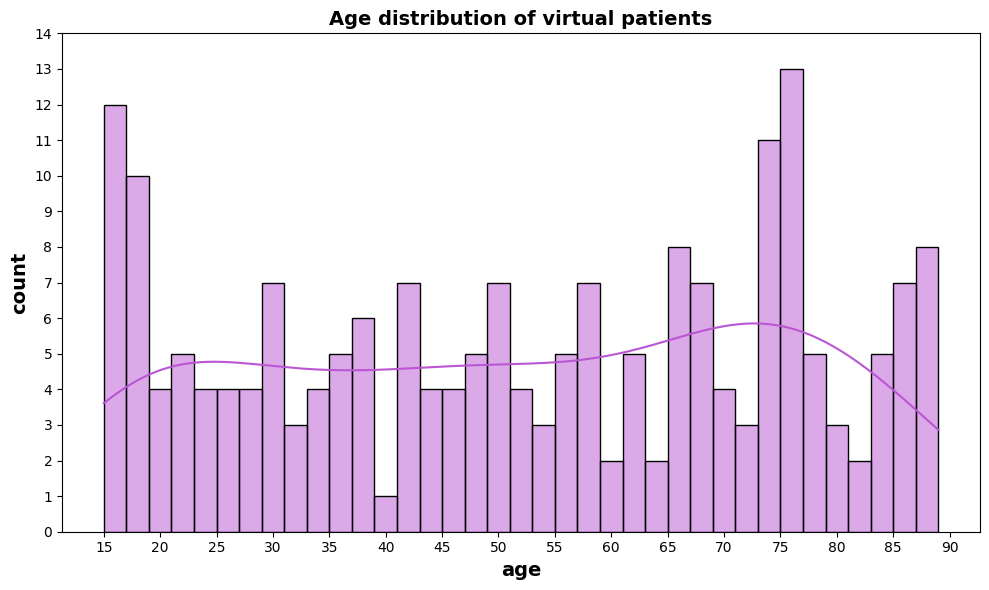

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_excel("virtual_patients.xlsx")
f, boxplot = plt.subplots(figsize=(10,6))
sns.histplot(df['age'], binwidth=2, color='mediumorchid', kde=True)
plt.ylabel("count", fontsize=14, color='black',  weight="bold")
plt.xlabel("age", fontsize=14, color='black', weight="bold")
plt.xticks(np.arange(15, 92,5)) 
plt.yticks(np.arange(0,15))
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.title('Age distribution of virtual patients', fontsize=14, color='black', weight="bold")
plt.tight_layout()
plt.savefig('ArticleFigures/HistPlot', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
plt.show()

Data Preprocessing

In [3]:
# Load the data
df = pd.read_excel("virtual_patients.xlsx")

# Convert categorical columns to numerical
df['gender'] = df['gender'].map({'man': 0, 'woman': 1})
df['diabetes'] = df['diabetes'].map({'yes': 1, 'no': 0})
df['CKD'] = df['CKD'].map({'yes': 1, 'no': 0})
df['CVD'] = df['CVD'].map({'yes': 1, 'no': 0})
df['smoking'] = df['smoking'].map({'yes': 1, 'no': 0})
df['recurrence'] = df['recurrence'].map({'yes': 1, 'no': 0})
df['readmission'] = df['readmission'].map({'yes': 1, 'no': 0})

# Define feature and target variables
X = df.drop(columns=['readmission'])
y = df['readmission']

# Scale numerical features
scaler = StandardScaler()
X[['age', 'Na', 'K', 'CBC', 'HBC', 'Plt', 'admission_time', 'discharge_time']] = scaler.fit_transform(X[['age', 'Na', 'K', 'CBC', 'HBC', 'Plt', 'admission_time', 'discharge_time']])


Define Models and Hyperparameter Grids

In [11]:
# Define models
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVC': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(),
  
}

# Define hyperparameter grids
param_grids = {
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 200],
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
    }
}


Simplified Bacterial Colony Optimization Algorithm

In [13]:
# Bacterial Colony Optimization function (simplified for example purposes)
def bacterial_colony_optimization(model, param_grid, X_train, y_train, X_val, y_val, n_iterations=30):
    best_params = {}
    best_score = 0

    for _ in range(n_iterations):
        params = {key: random.choice(values) for key, values in param_grid.items()}
        model.set_params(**params)
        model.fit(X_train, y_train)
        score = model.score(X_val, y_val)
        
        if score > best_score:
            best_score = score
            best_params = params
    
    return best_params, best_score

# Nested cross-validation with Bacterial Colony Optimization
def nested_cross_validation_and_bco(X, y, models, param_grids):
    results = []
    outer_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
        for model_name in models:
            model = models[model_name]
            param_grid = param_grids[model_name]
            
            best_inner_params = None
            best_inner_score = 0
            
            for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
                X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
                y_inner_train, y_inner_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]
                
                # Perform BCO
                best_params, best_score = bacterial_colony_optimization(model, param_grid, X_inner_train, y_inner_train, X_inner_val, y_inner_val)
                
                if best_score > best_inner_score:
                    best_inner_score = best_score
                    best_inner_params = best_params
            
            # Evaluate on outer test set
            model.set_params(**best_inner_params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            
            results.append({
                'Model': model_name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'ROC-AUC': roc_auc,
                'Best Params': best_inner_params
            })

            # Save the best model for the outer loop fold
            with open(f"best_model_fold_{fold}_{model_name}.pkl", "wb") as file:
                pickle.dump(model, file)
    
    return pd.DataFrame(results)

# Run the nested cross-validation and hyperparameter optimization
results_df = nested_cross_validation_and_bco(X, y, models, param_grids)




In [14]:
# Print the results
print(results_df)

                     Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC  \
0       LogisticRegression     0.625   0.760000  0.678571  0.716981  0.589286   
1   DecisionTreeClassifier     0.475   0.666667  0.500000  0.571429  0.458333   
2   RandomForestClassifier     0.500   0.666667  0.571429  0.615385  0.452381   
3                      SVC     0.550   0.708333  0.607143  0.653846  0.511905   
4     KNeighborsClassifier     0.400   0.583333  0.500000  0.538462  0.333333   
5       LogisticRegression     0.500   0.571429  0.666667  0.615385  0.458333   
6   DecisionTreeClassifier     0.525   0.692308  0.375000  0.486486  0.562500   
7   RandomForestClassifier     0.525   0.586207  0.708333  0.641509  0.479167   
8                      SVC     0.525   0.586207  0.708333  0.641509  0.479167   
9     KNeighborsClassifier     0.625   0.680000  0.708333  0.693878  0.604167   
10      LogisticRegression     0.400   0.500000  0.541667  0.520000  0.364583   
11  DecisionTreeClassifier  

In [15]:
# Save the results to an Excel file
results_df.to_excel("final_results.xlsx", index=False)

Heatmap

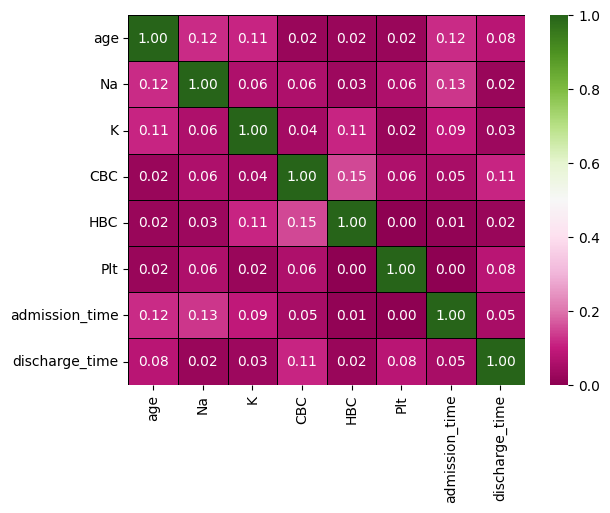

In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
datafile = pd.read_excel("virtual_patients.xlsx")
X = datafile.drop(columns=['gender', 'diabetes','CKD','CVD','smoking','recurrence','readmission'])

correlation = X.corr(method='spearman')
sns.heatmap(round(np.abs(correlation),2),vmin=0, vmax=1,  annot=True,   cbar=True, cmap='PiYG'
               ,  fmt=".2f",   linecolor='black', linewidths=0.5)
plt.savefig('ArticleFigures/Heatmap', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
plt.show()

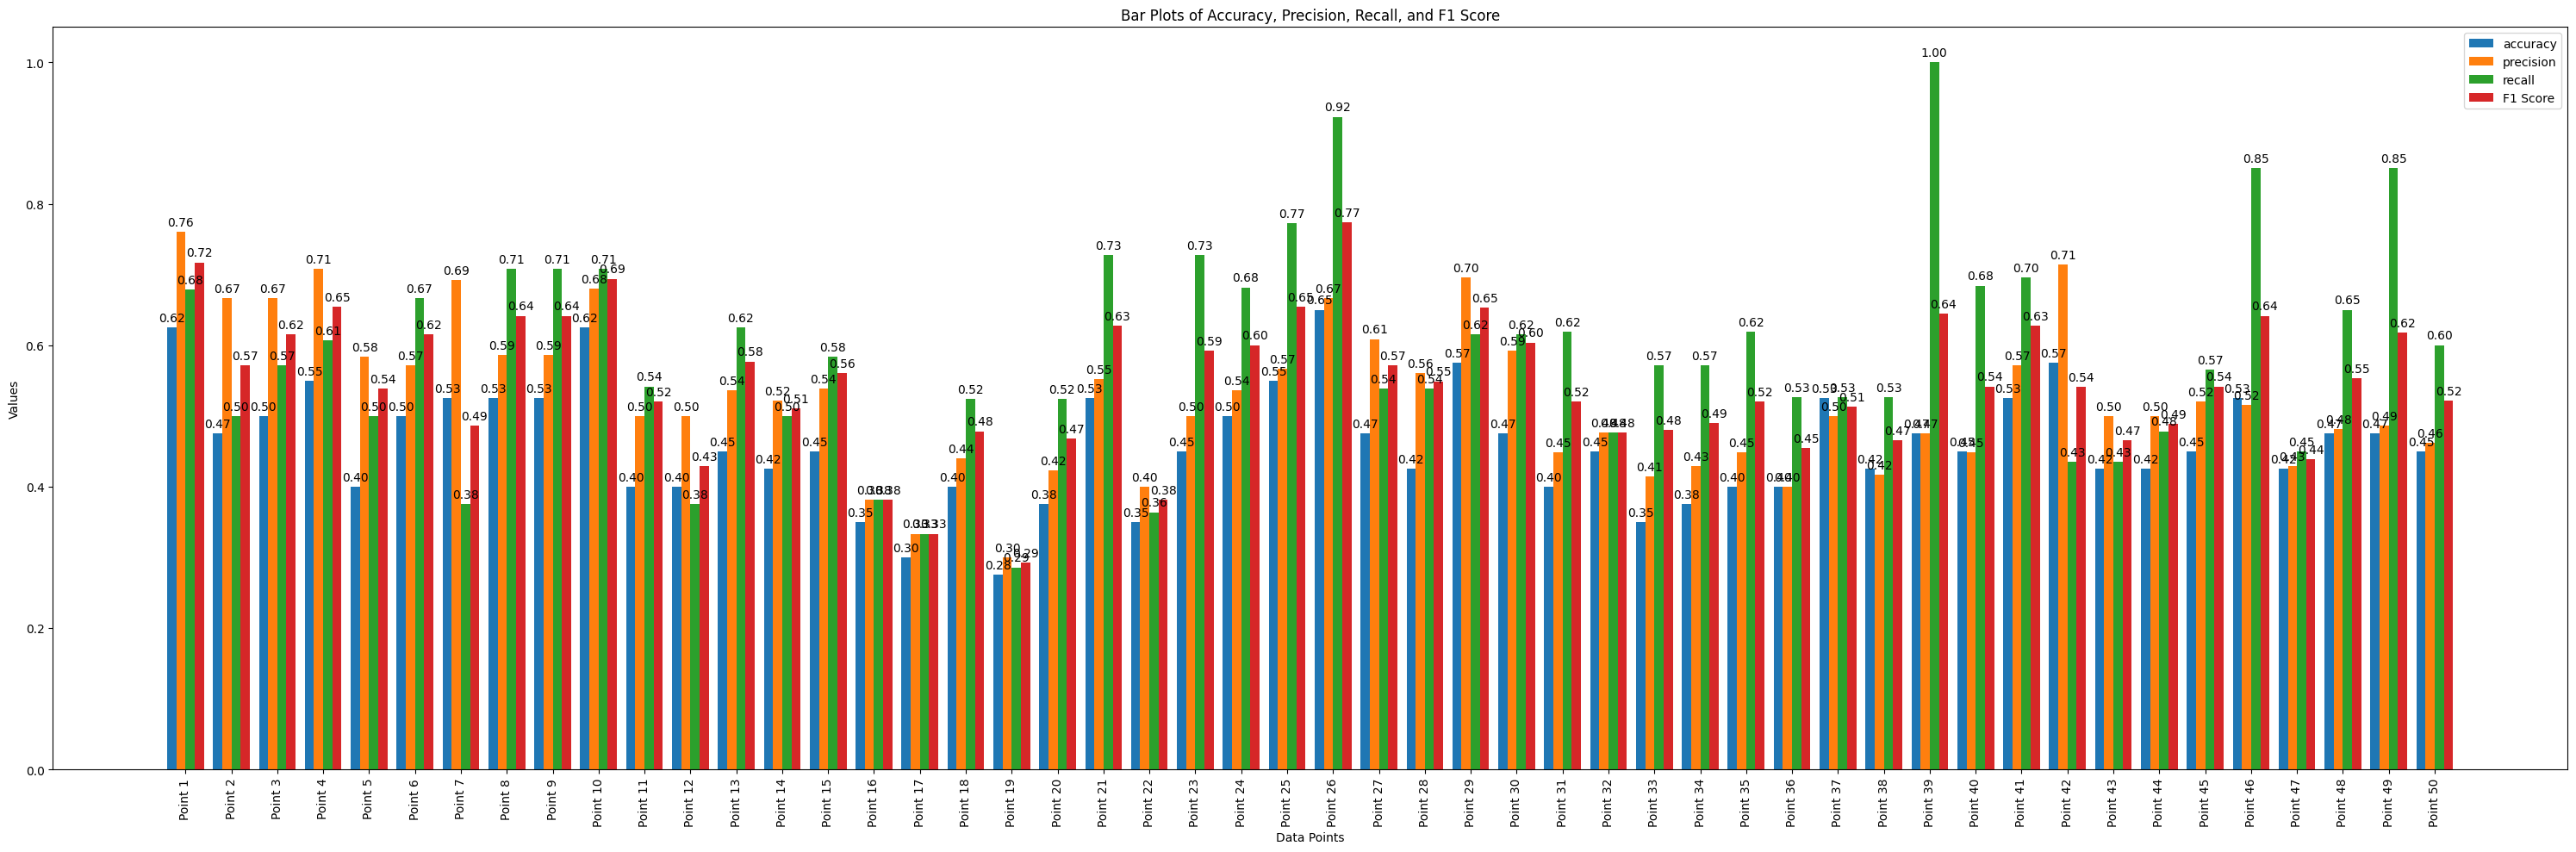

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read the data from the Excel file
data = pd.read_excel("final_results.xlsx")

# Extract the columns
accuracy = data.iloc[:, 1]
precision = data.iloc[:, 2]
recall = data.iloc[:, 3]
F1_Score = data.iloc[:, 4]

# Number of data points
x = np.arange(50)

# Width of the bars
width = 0.2

# Create the figure and axes
f, barplot = plt.subplots(figsize=(30, 10))

# Plot each set of bars
barplot.bar(x - 1.5*width, accuracy, width=width, label='accuracy')
barplot.bar(x - 0.5*width, precision, width=width, label='precision')
barplot.bar(x + 0.5*width, recall, width=width, label='recall')
barplot.bar(x + 1.5*width, F1_Score, width=width, label='F1 Score')

# Add some text for labels, title, and custom x-axis tick labels, etc.
barplot.set_xlabel('Data Points')
barplot.set_ylabel('Values')
barplot.set_title('Bar Plots of Accuracy, Precision, Recall, and F1 Score')
barplot.set_xticks(x)
barplot.set_xticklabels([f'Point {i}' for i in range(1, 51)], rotation=90)
barplot.legend()

# Function to auto-label bars with their values
def autolabel(rects):
    """Attach a text label above each bar in rects, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        barplot.annotate(f'{height:.2f}',
                         xy=(rect.get_x() + rect.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')

# Apply autolabel function to each set of bars
autolabel(barplot.patches)
plt.tight_layout()
plt.savefig('ArticleFigures/barplot_scores', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
# Display the plot
plt.show()


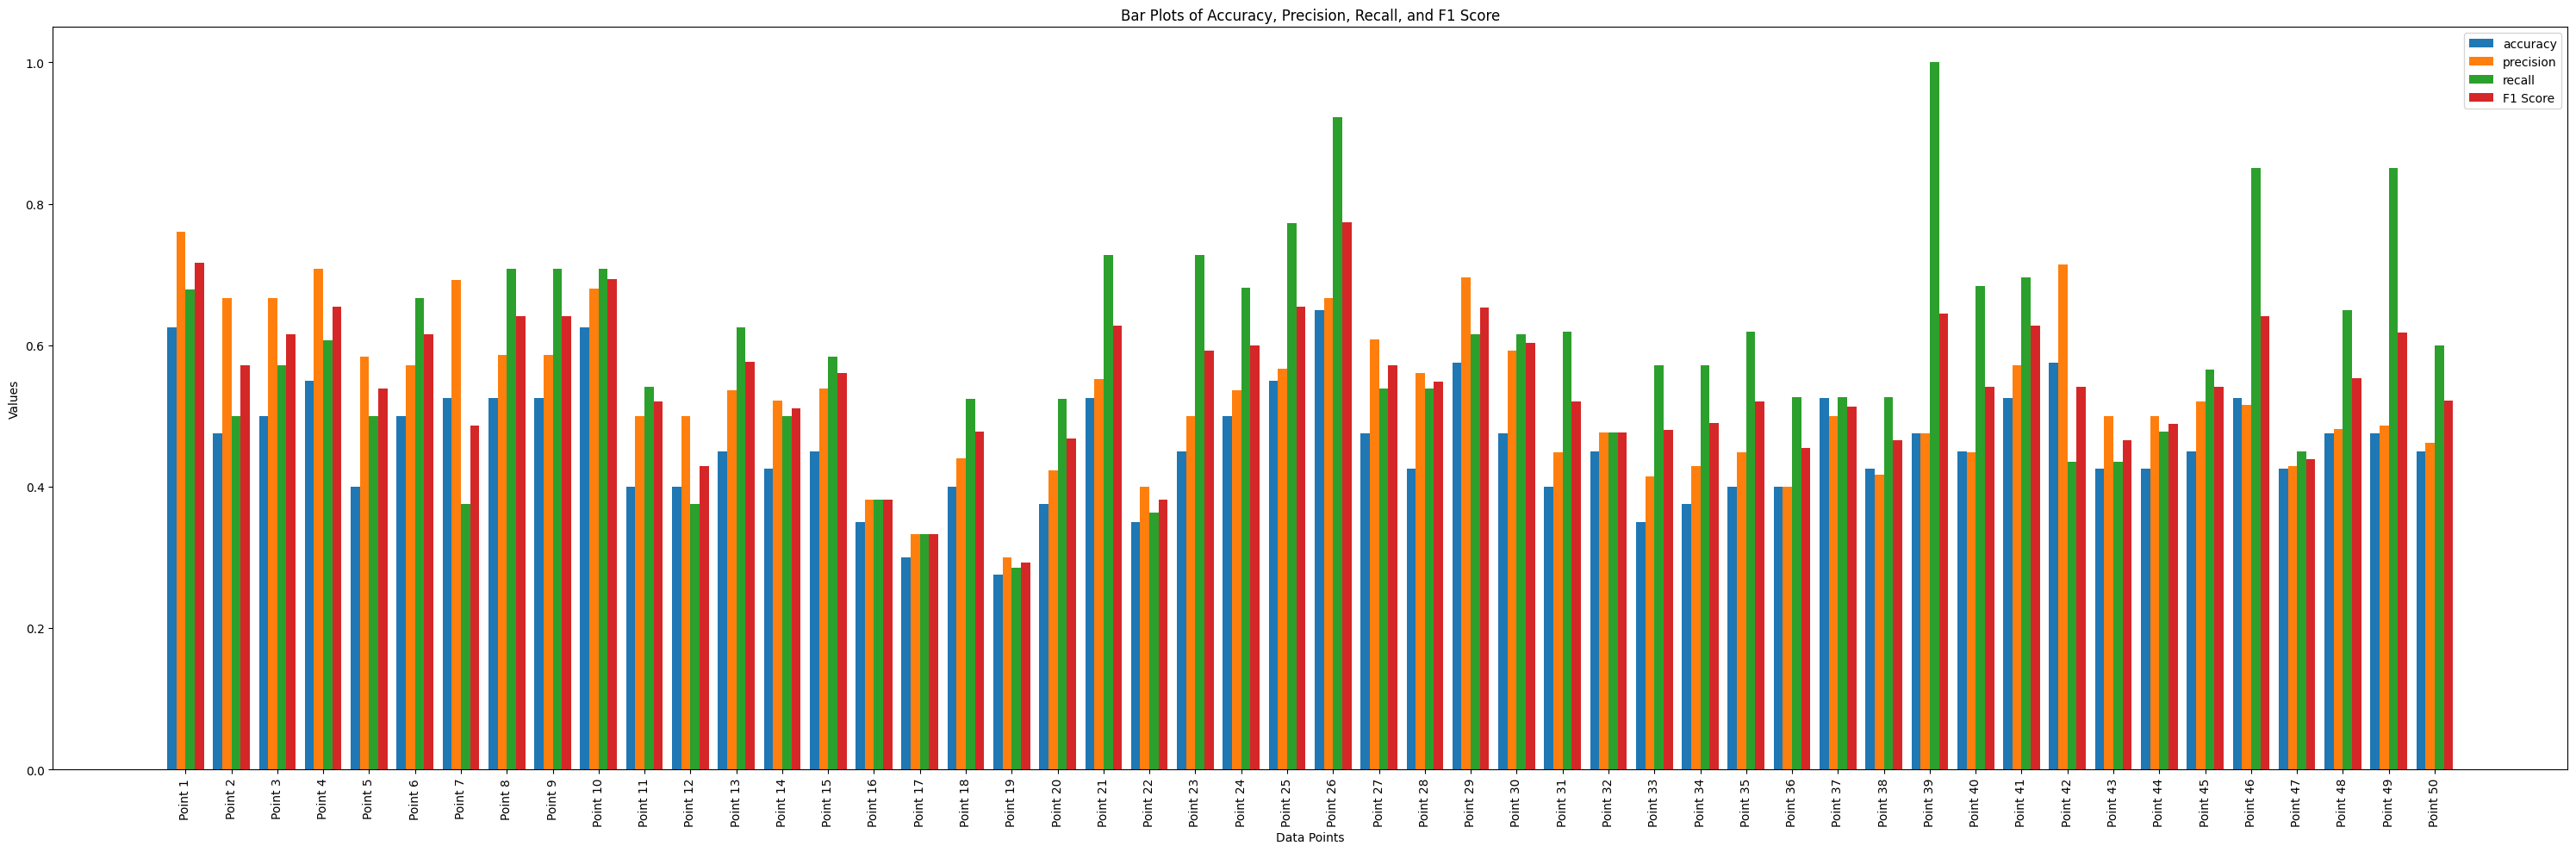

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read the data from the Excel file
data = pd.read_excel("final_results.xlsx")

# Extract the columns
accuracy = data.iloc[:, 1]
precision = data.iloc[:, 2]
recall = data.iloc[:, 3]
F1_Score = data.iloc[:, 4]

# Number of data points
x = np.arange(50)

# Width of the bars
width = 0.2

# Create the figure and axes
f, barplot = plt.subplots(figsize=(30, 10))

# Plot each set of bars
barplot.bar(x - 1.5*width, accuracy, width=width, label='accuracy')
barplot.bar(x - 0.5*width, precision, width=width, label='precision')
barplot.bar(x + 0.5*width, recall, width=width, label='recall')
barplot.bar(x + 1.5*width, F1_Score, width=width, label='F1 Score')

# Add some text for labels, title, and custom x-axis tick labels, etc.
barplot.set_xlabel('Data Points')
barplot.set_ylabel('Values')
barplot.set_title('Bar Plots of Accuracy, Precision, Recall, and F1 Score')
barplot.set_xticks(x)
barplot.set_xticklabels([f'Point {i}' for i in range(1, 51)], rotation=90)
barplot.legend()


plt.tight_layout()
plt.savefig('ArticleFigures/barplot_scores_withoutnumbers', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
# Display the plot
plt.show()


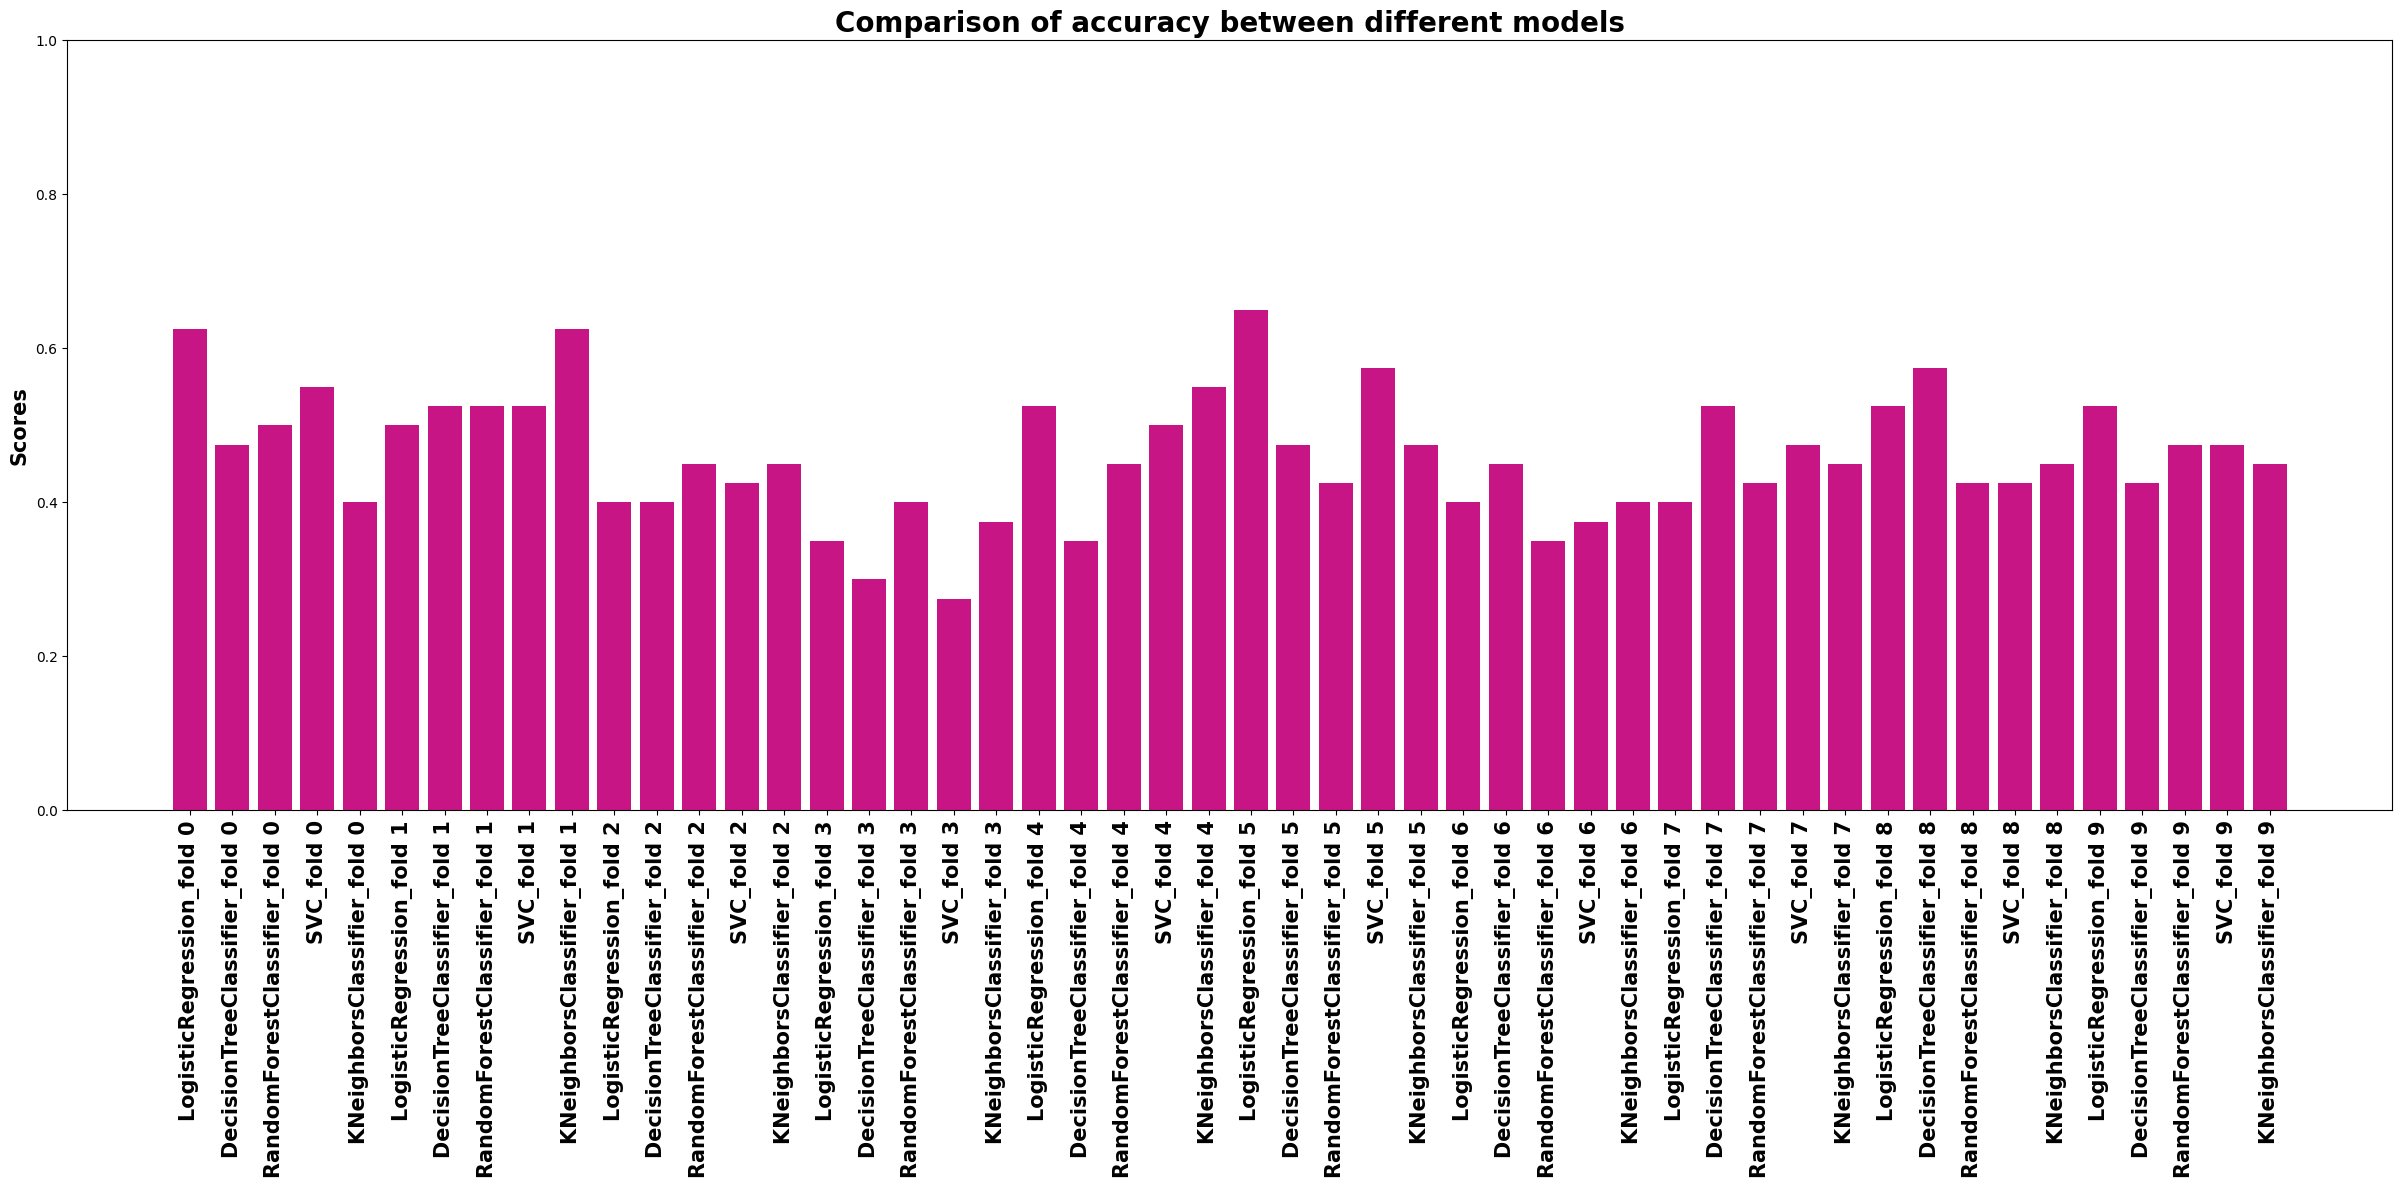

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Read the data from the Excel file
data = pd.read_excel("final_results_for_bar_plot.xlsx")

# Extract the columns
accuracy = data.iloc[:, 1]
model = data.iloc[:, 7]
# Create the figure and axes
f, barplot = plt.subplots(figsize=(30, 10))
plt.bar( model, accuracy, color='mediumvioletred' )
plt.xticks(rotation=90, fontsize=15,  weight='bold')
plt.ylabel("Scores", fontsize=15, color = 'black', weight='bold')
plt.ylim([0,1])
plt.title("Comparison of accuracy between different models", fontsize=20, color = 'black', weight='bold')

plt.savefig('ArticleFigures/barplot_accuracy', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
plt.show()

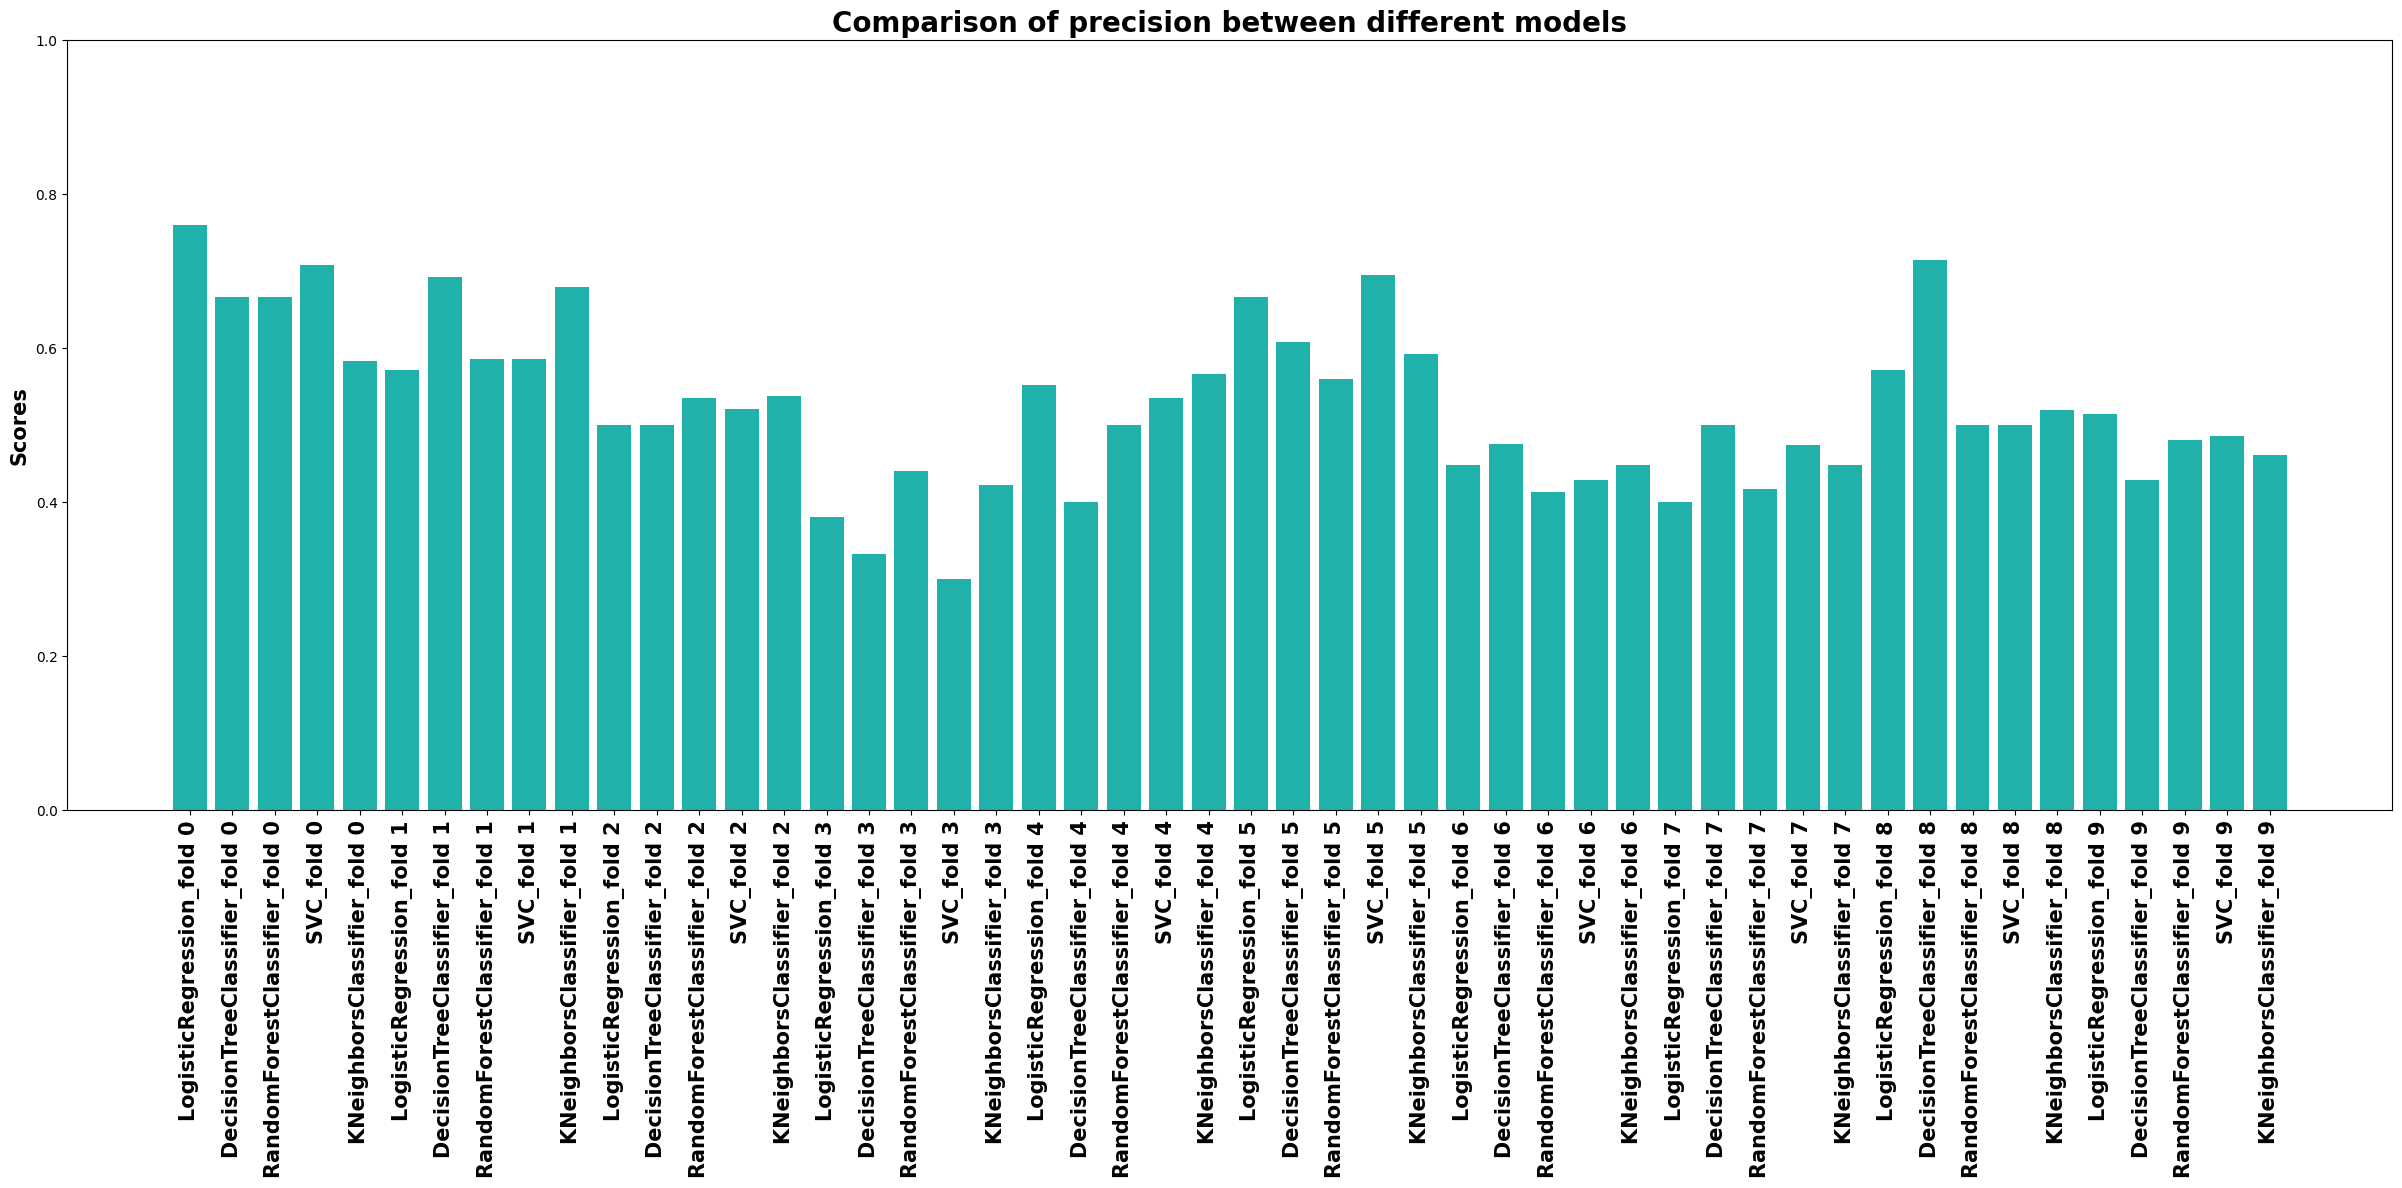

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Read the data from the Excel file
data = pd.read_excel("final_results_for_bar_plot.xlsx")

# Extract the columns
precision = data.iloc[:, 2]
model = data.iloc[:, 7]
# Create the figure and axes
f, barplot = plt.subplots(figsize=(30, 10))
plt.bar( model, precision, color='lightseagreen' )
plt.xticks(rotation=90, fontsize=15,  weight='bold')
plt.ylabel("Scores", fontsize=15, color = 'black', weight='bold')
plt.ylim([0,1])
plt.title("Comparison of precision between different models", fontsize=20, color = 'black', weight='bold')
plt.savefig('ArticleFigures/barplot_precision', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
plt.show()

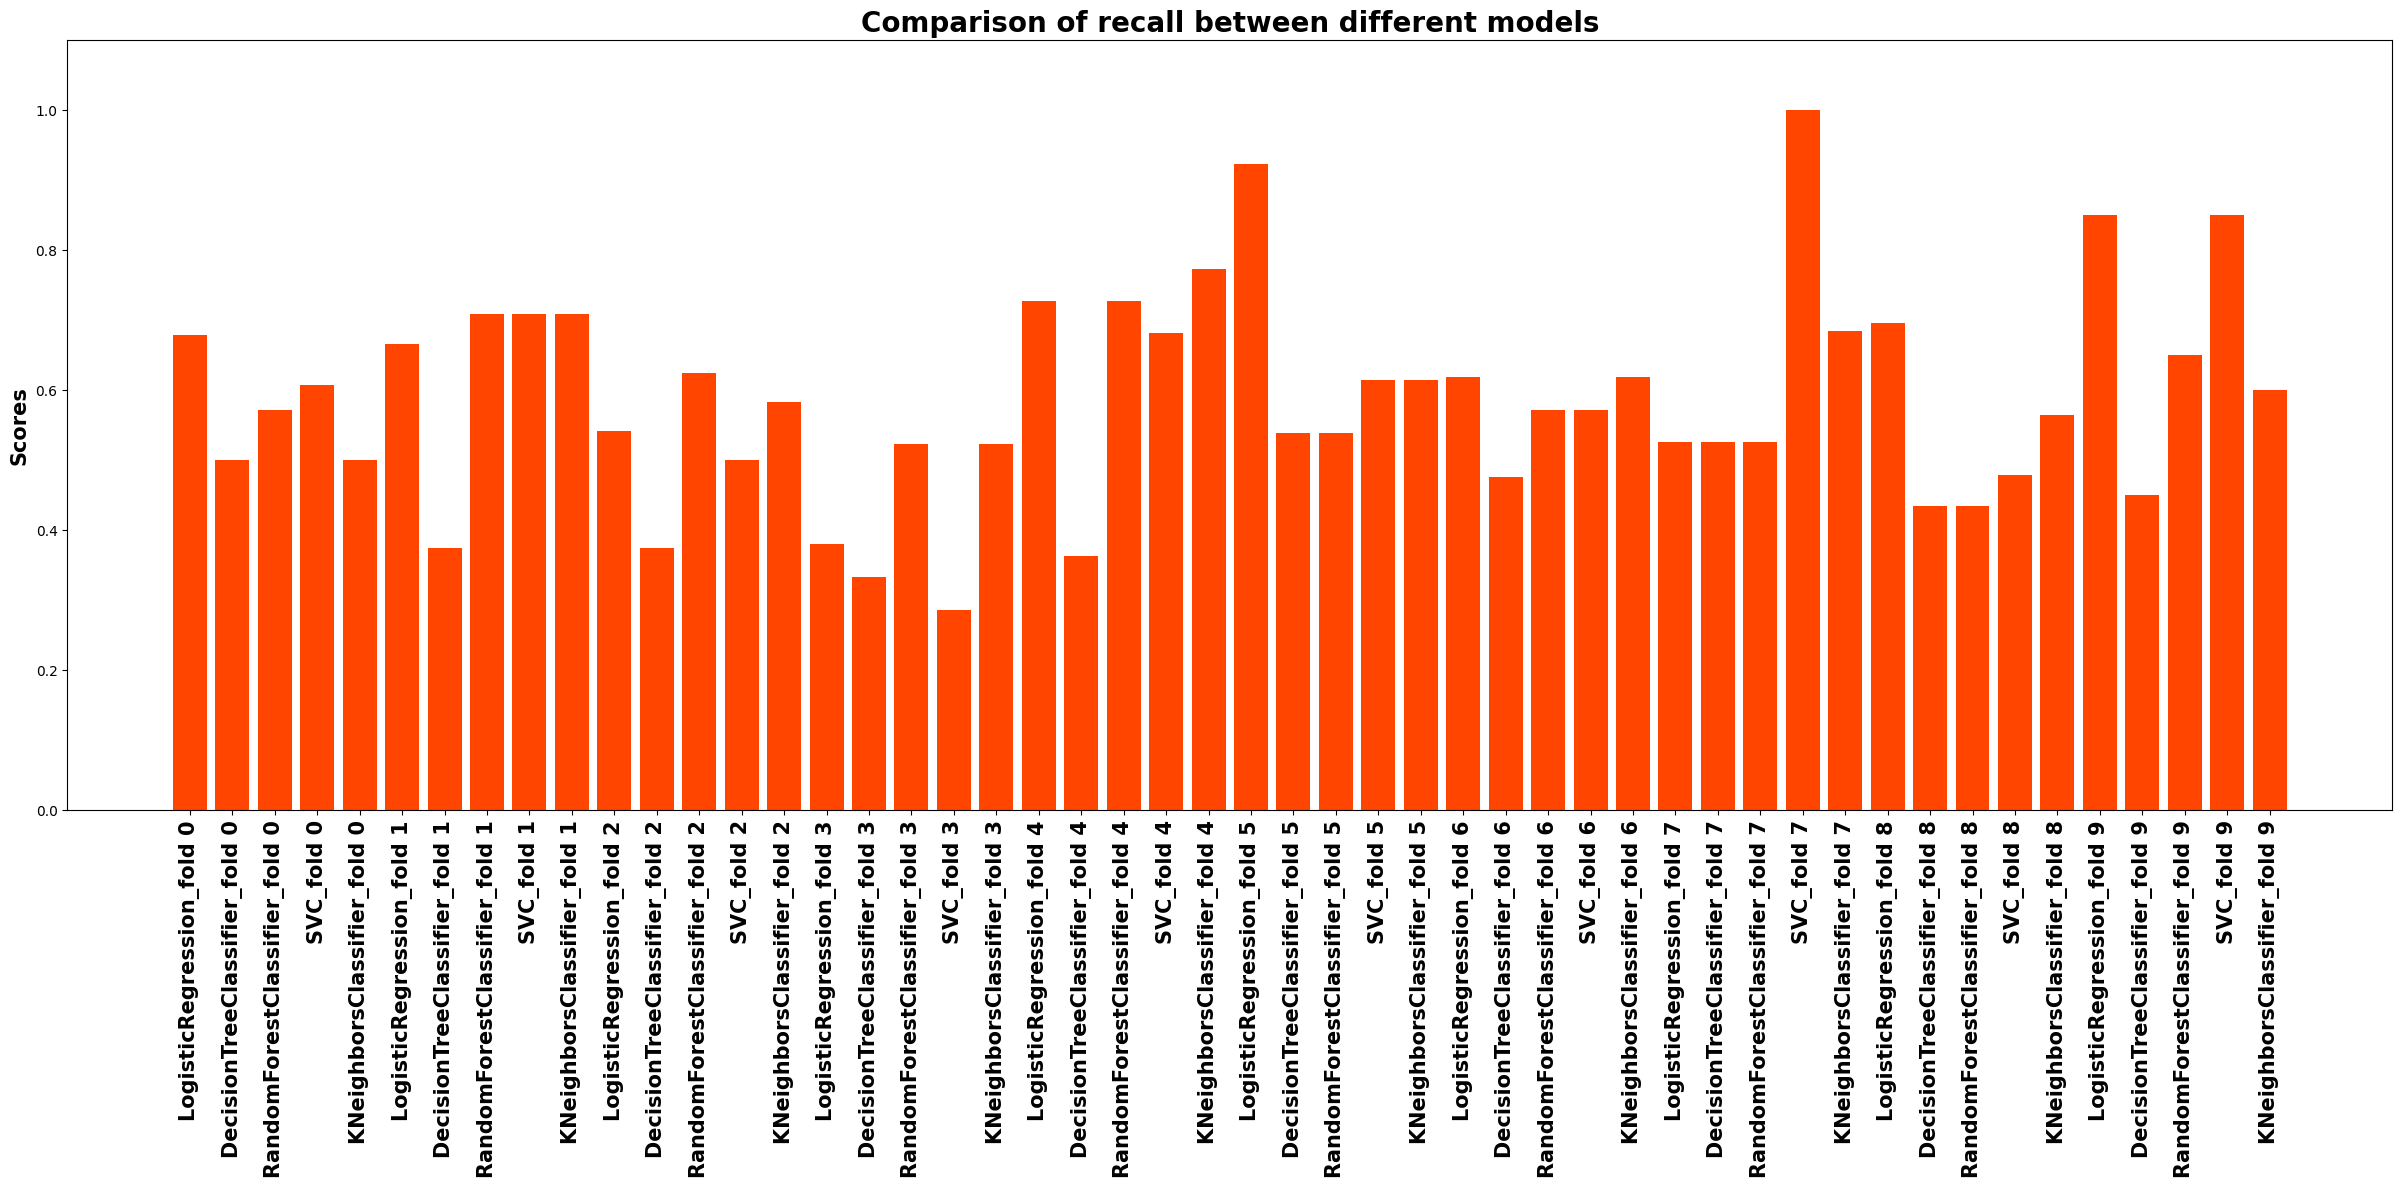

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Read the data from the Excel file
data = pd.read_excel("final_results_for_bar_plot.xlsx")

# Extract the columns
recall = data.iloc[:, 3]
model = data.iloc[:, 7]
# Create the figure and axes
f, barplot = plt.subplots(figsize=(30, 10))
plt.bar( model, recall, color='orangered' )
plt.xticks(rotation=90, fontsize=15,  weight='bold')
plt.ylabel("Scores", fontsize=15, color = 'black', weight='bold')
plt.ylim([0,1.1])
plt.title("Comparison of recall between different models", fontsize=20, color = 'black', weight='bold')
plt.savefig('ArticleFigures/barplot_recall', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
plt.show()

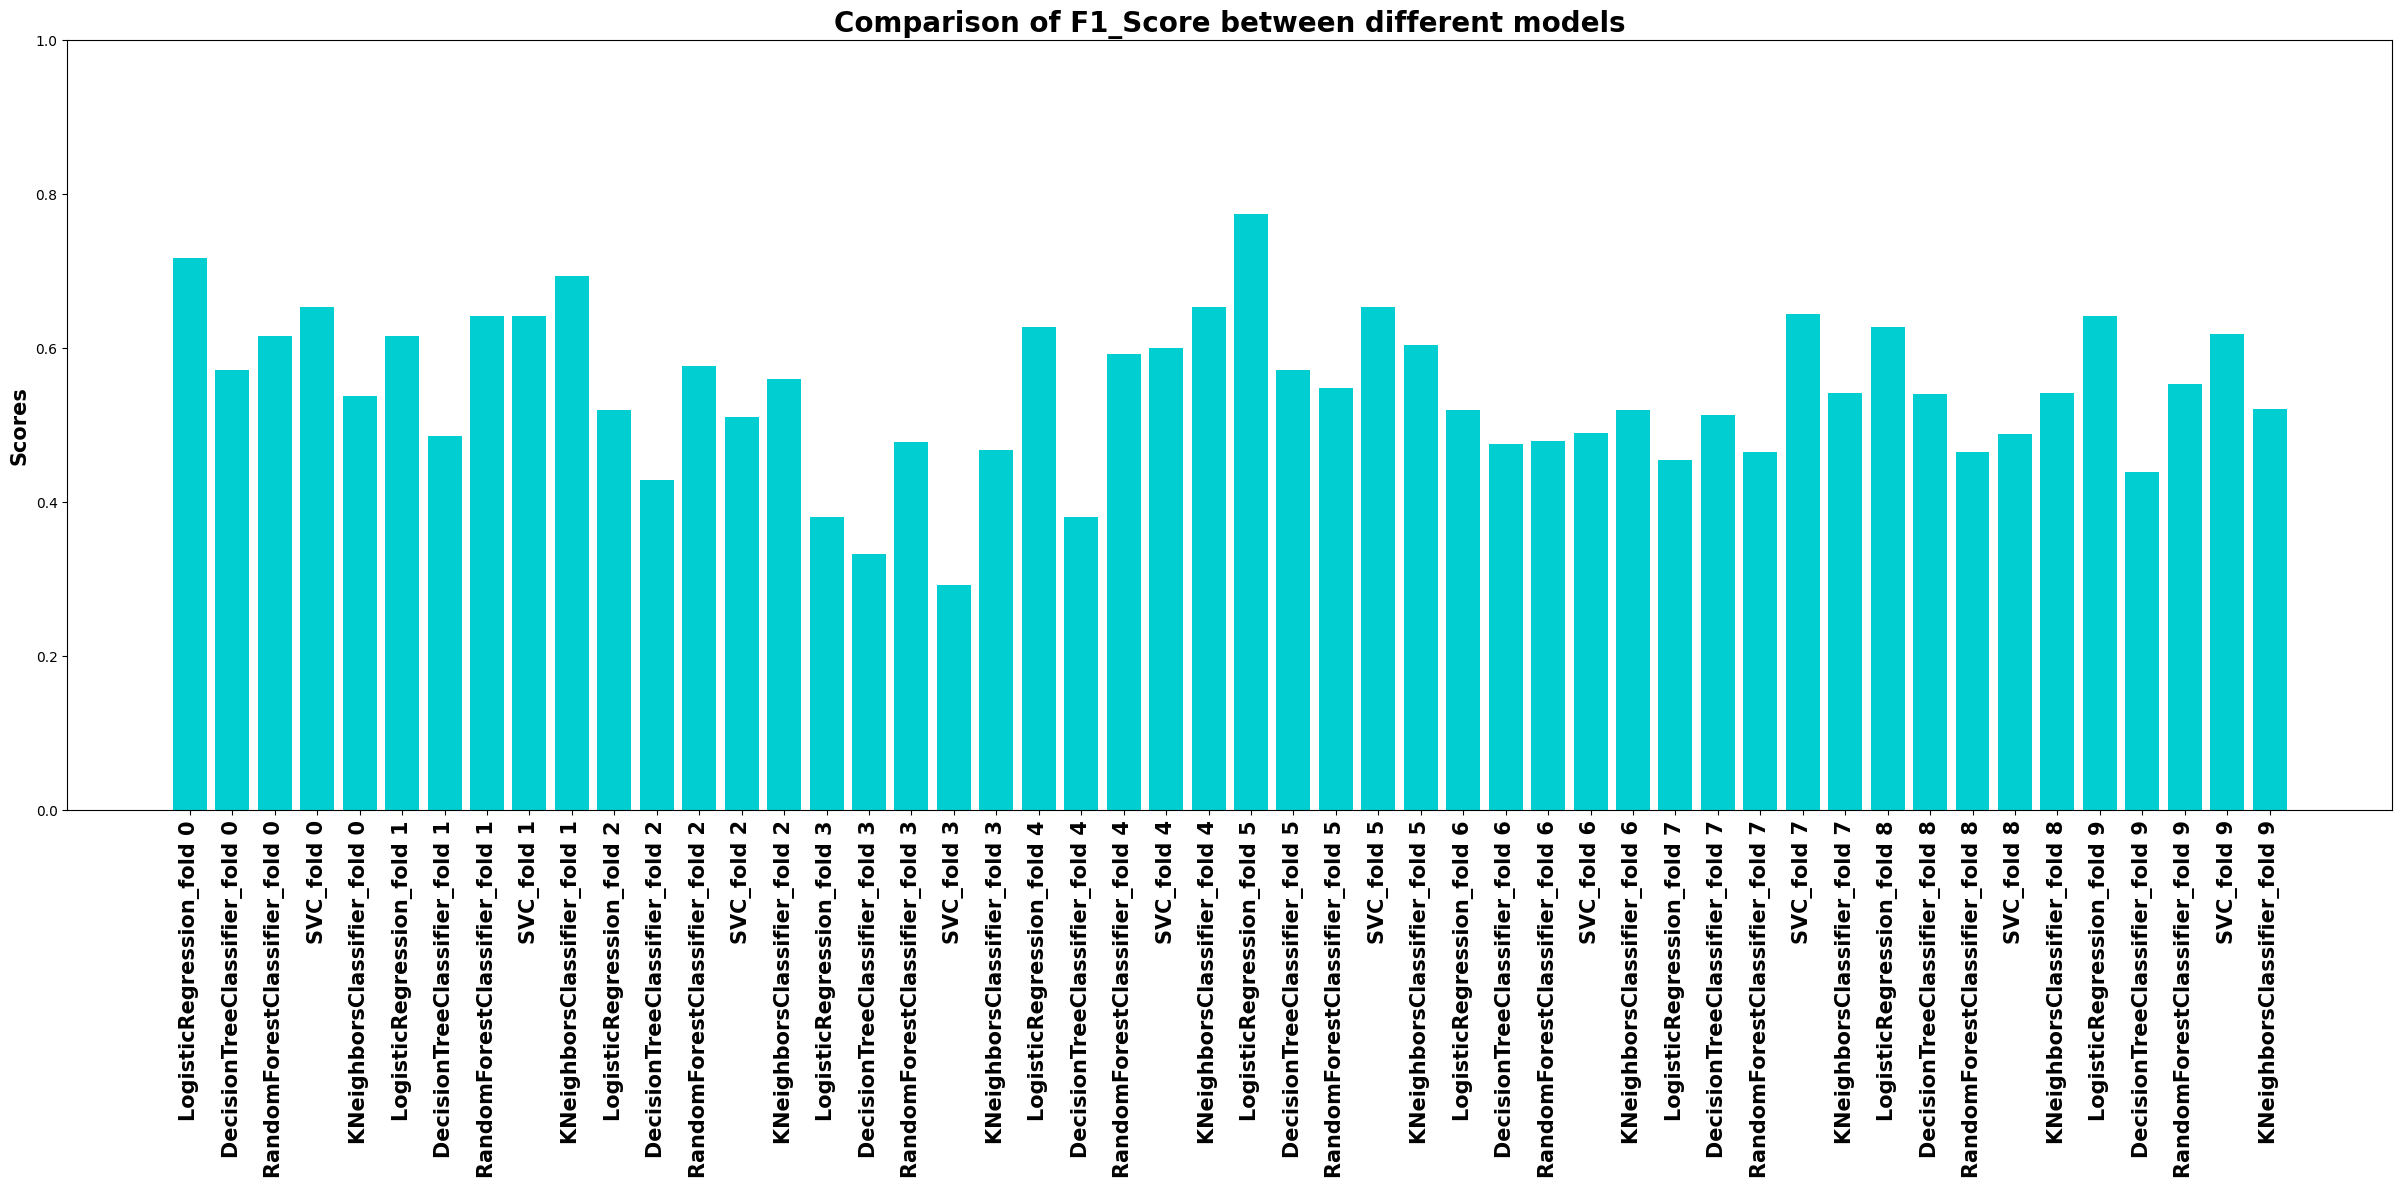

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Read the data from the Excel file
data = pd.read_excel("final_results_for_bar_plot.xlsx")

# Extract the columns
F1_Score = data.iloc[:, 4]
model = data.iloc[:, 7]
# Create the figure and axes
f, barplot = plt.subplots(figsize=(30, 10))
plt.bar( model, F1_Score, color='darkturquoise' )
plt.xticks(rotation=90, fontsize=15,  weight='bold')
plt.ylabel("Scores", fontsize=15, color = 'black', weight='bold')
plt.ylim([0,1])
plt.title("Comparison of F1_Score between different models", fontsize=20, color = 'black', weight='bold')
plt.savefig('ArticleFigures/barplot_F1_Score', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
plt.show()

base on best Accuracy

In [16]:
fold = 6  # Specify the fold you are interested in
model_name = 'LogisticRegression'

# Load the best model
with open(f"best_model_fold_{fold}_{model_name}.pkl", "rb") as file:
    best_model = pickle.load(file)

best_model.fit(X, y)

# Calculate SHAP values
explainer = shap.Explainer(best_model, X)
shap_values = explainer(X)

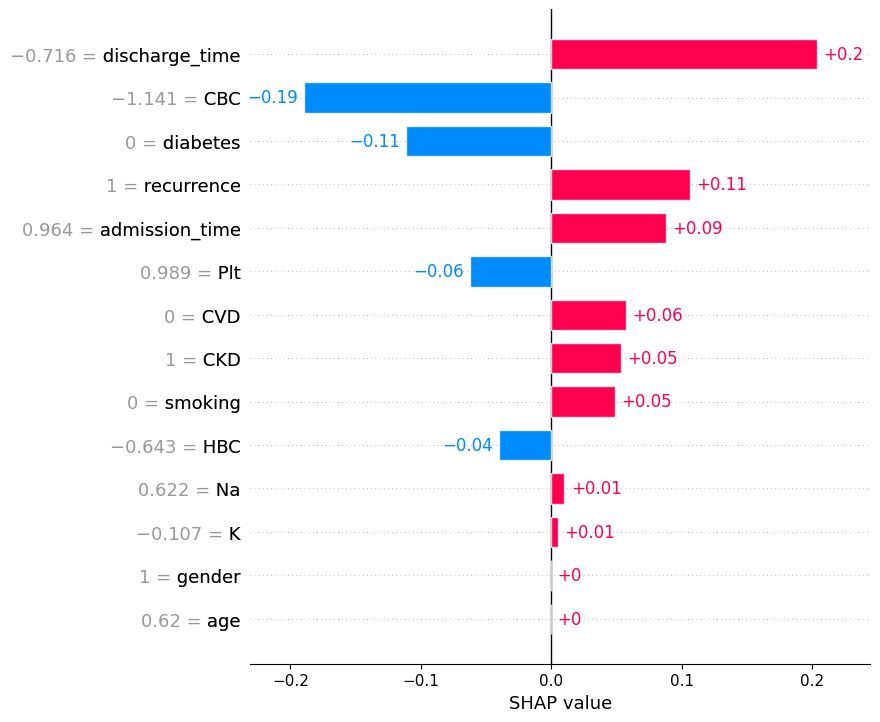

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
shap.plots.bar(shap_values[0],  max_display=15)
plt.savefig('ArticleFigures/beeswarm', dpi=600, format = 'png', transparent=True, bbox_inches='tight')

LIME

c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


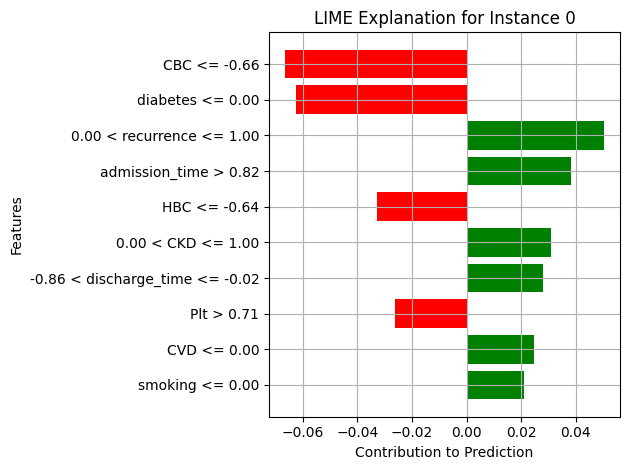

In [28]:
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns.tolist(),
    class_names=['No Readmission', 'Readmission'],
    mode='classification'
)

# Explain a single prediction
i = 0  # Index of the instance to explain
exp = explainer.explain_instance(X.iloc[i].values, best_model.predict_proba)


# Customize the plot
fig = exp.as_pyplot_figure()

# Enhance plot aesthetics
plt.title('LIME Explanation for Instance {}'.format(i))
plt.xlabel('Contribution to Prediction')
plt.ylabel('Features')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()